In [82]:
## Algorithms in Structural Biology final project 2023
##Instructors: Ioannis Emiris Evangelia Chrysina
## Marina Thalassini Filippidou 7115152200032

## Clustering of the conformations glycogen phosphorylase active site using the angles of the rotamers

In [83]:
import time 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN


from sklearn.utils import check_random_state
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.manifold import TSNE

from glob import glob

from sklearn.manifold import MDS

import re
from collections import defaultdict



## Loading the angles dataset

In [84]:
# Change directory
new_directory = '/home/marina/Downloads/datasets'
os.chdir(new_directory)

# Import angles CSV file and convert it to DataFrame
angles = 'angleDataset.csv'
df_angles = pd.read_csv(angles)

column_names_angles=['conformations','chi1','chi2','chi3','chi4','chi5','chi6','chi7','chi8','chi9','chi10',
             'chi11','chi12','chi13','chi14','chi15','chi16','chi17','chi18','chi19','chi20',
             'chi21','chi22','chi23','chi24','chi25']

df_angles.columns = column_names_angles

# Now you can work with the DataFrame
print(df_angles.head())


            conformations      chi1      chi2      chi3      chi4      chi5  \
0  1-1-1-1-2-1-15-2-2-3-1 -1.170242  3.141543 -0.175281 -1.135062  3.038222   
1  1-3-1-1-2-1-15-2-2-1-1 -1.170242  3.141543 -0.175281 -3.089263  1.133880   
2  1-3-1-1-2-1-15-2-2-3-1 -1.170242  3.141543 -0.175281 -3.089263  1.133880   
3  1-4-1-1-2-1-15-2-2-1-1 -1.170242  3.141543 -0.175281 -3.002066  2.564999   
4  1-4-1-1-2-1-15-2-2-3-1 -1.170242  3.141543 -0.175281 -3.002066  2.564999   

       chi6      chi7      chi8      chi9  ...     chi16     chi17     chi18  \
0 -1.133942 -0.366574 -1.221665 -0.261967  ... -3.140819  1.482803  0.000334   
1 -1.133942 -0.366574 -1.221665 -0.261967  ... -3.140819  1.482803  0.000334   
2 -1.133942 -0.366574 -1.221665 -0.261967  ... -3.140819  1.482803  0.000334   
3 -1.133942 -0.366574 -1.221665 -0.261967  ... -3.140819  1.482803  0.000334   
4 -1.133942 -0.366574 -1.221665 -0.261967  ... -3.140819  1.482803  0.000334   

      chi19     chi20     chi21     chi22   

In [85]:
# Remove the first column
angles = df_angles.iloc[:, 1:]
#Define the rotamers
conformations= df_angles["conformations"]

# Print the dimensions of the DataFrame
print("Dimensions: ", angles.shape)


Dimensions:  (69119, 25)


In [86]:
conformations

0        1-1-1-1-2-1-15-2-2-3-1
1        1-3-1-1-2-1-15-2-2-1-1
2        1-3-1-1-2-1-15-2-2-3-1
3        1-4-1-1-2-1-15-2-2-1-1
4        1-4-1-1-2-1-15-2-2-3-1
                  ...          
69114    4-1-6-5-5-3-21-3-2-3-3
69115    4-3-6-5-5-3-21-3-2-1-3
69116    4-3-6-5-5-3-21-3-2-3-3
69117    4-4-6-5-5-3-21-3-2-1-3
69118    4-4-6-5-5-3-21-3-2-3-3
Name: conformations, Length: 69119, dtype: object

## Calculate conformations weights

In [87]:
def readAminoFreq(filepath):
    aminofrequency = {}
    files = glob(filepath + "/*")
    #files=sorted(files,reverse=True)
    for filename in files:
        fileID = filename.split("/")[-1]
        res = fileID[:3]
        idx = int(fileID[3:-4])
        
        with open(filename, 'r') as f:
            aminofrequency[idx] = {}
            for line in f:
                if line != "\n":
                    rot, freq = line.split()
                    aminofrequency[idx][rot] = freq

    return aminofrequency

In [88]:
def conformation_weights(aminofrequency,conf):
  
    conf = conf.split("-")
    # Convert the list of strings to a list of integers
    conf = [int(num) for num in conf] 

    
    #sort the dictionary
    sorted_freqs = {key: aminofrequency[key] for key in sorted(aminofrequency.keys())}
    #get the keys of the dictionary into a list
    keys_freq=list(sorted_freqs)
    #get the frequency value for each rotamer in the conformation
    freq_values = [sorted_freqs[keys_freq[i]][str(conf[i])] for i in range(len(conf))]
    #convert the strings to float
    freq_values = [float(x) for x in freq_values]

    #get their product
    from functools import reduce
    freq_product = reduce(lambda x, y: x * y if y != 0 else x,freq_values)

    return freq_product

In [89]:
#Specify the path of the rotamers_weights txt files
filepath="/home/marina/Downloads/code/results/rotamers_weights"
aminofrequency=readAminoFreq(filepath)

In [90]:
weights=[]
for conf in conformations:
    #print(conf)
    weight_conf=conformation_weights(aminofrequency,conf)
    weights.append(weight_conf)

In [91]:
df_angles['weights'] = weights

print(df_angles)

                conformations      chi1      chi2      chi3      chi4  \
0      1-1-1-1-2-1-15-2-2-3-1 -1.170242  3.141543 -0.175281 -1.135062   
1      1-3-1-1-2-1-15-2-2-1-1 -1.170242  3.141543 -0.175281 -3.089263   
2      1-3-1-1-2-1-15-2-2-3-1 -1.170242  3.141543 -0.175281 -3.089263   
3      1-4-1-1-2-1-15-2-2-1-1 -1.170242  3.141543 -0.175281 -3.002066   
4      1-4-1-1-2-1-15-2-2-3-1 -1.170242  3.141543 -0.175281 -3.002066   
...                       ...       ...       ...       ...       ...   
69114  4-1-6-5-5-3-21-3-2-3-3 -3.089504  3.141017 -0.001498 -1.135062   
69115  4-3-6-5-5-3-21-3-2-1-3 -3.089504  3.141017 -0.001498 -3.089263   
69116  4-3-6-5-5-3-21-3-2-3-3 -3.089504  3.141017 -0.001498 -3.089263   
69117  4-4-6-5-5-3-21-3-2-1-3 -3.089504  3.141017 -0.001498 -3.002066   
69118  4-4-6-5-5-3-21-3-2-3-3 -3.089504  3.141017 -0.001498 -3.002066   

           chi5      chi6      chi7      chi8      chi9  ...     chi17  \
0      3.038222 -1.133942 -0.366574 -1.221665 -0.

## Scaling the data

In [92]:
# Scale the data using StandardScaler
scaler = StandardScaler()
scaled_data_standard_angles = scaler.fit_transform(angles)

# Scale the data using MinMaxScaler
minmax_scaler = MinMaxScaler()
final_angles = minmax_scaler.fit_transform(scaled_data_standard_angles)


# Dimensionality Reduction

## PCA

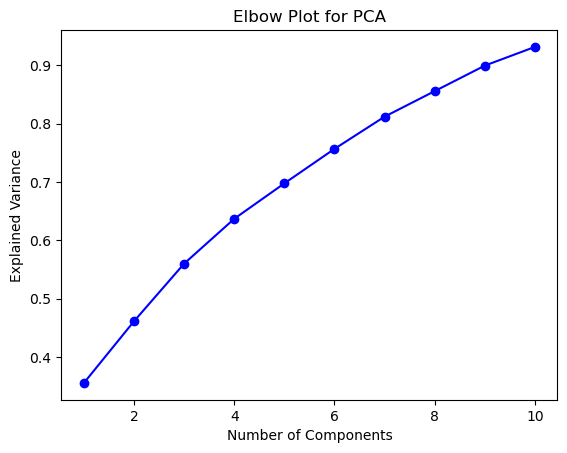

In [93]:
# Perform PCA with different numbers of components
n_components = np.arange(1, 11)  # Number of components to try
explained_variances = []

for n in n_components:
    pca = PCA(n_components=n)
    pca.fit(angles)
    explained_variances.append(pca.explained_variance_ratio_.sum())

# Plot the explained variances
plt.plot(n_components, explained_variances, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Elbow Plot for PCA')
plt.show()

In [94]:
#we kepp 7 pc's in order to have ~0.8 of explained variance
# Applying dimensionality reduction
pca = PCA(n_components=7)
pca.fit(angles)
pca_angles = pca.transform(angles)

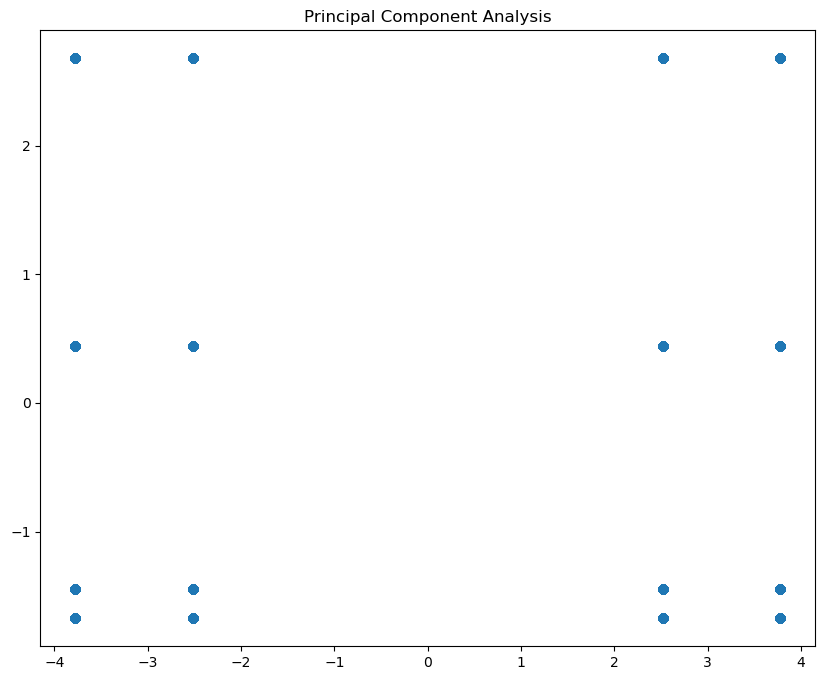

In [95]:
# Plot the PCA components
plt.figure(figsize=(10, 8))
plt.scatter(pca_angles[:, 0], pca_angles[:, 1])
plt.title('Principal Component Analysis')

# Show the plot
plt.show()

## UMAP and t-SNE

In [96]:
# Run UMAP with 2 and 3 components
umap_result_2d = UMAP(n_components=2,random_state=42).fit_transform(angles)
#umap_result_3d = UMAP(n_components=3).fit_transform(angles)

# Run t-SNE with 2 and 3 components
tsne_result_2d = TSNE(n_components=2,random_state=42).fit_transform(angles)
#tsne_result_3d = TSNE(n_components=3).fit_transform(angles)


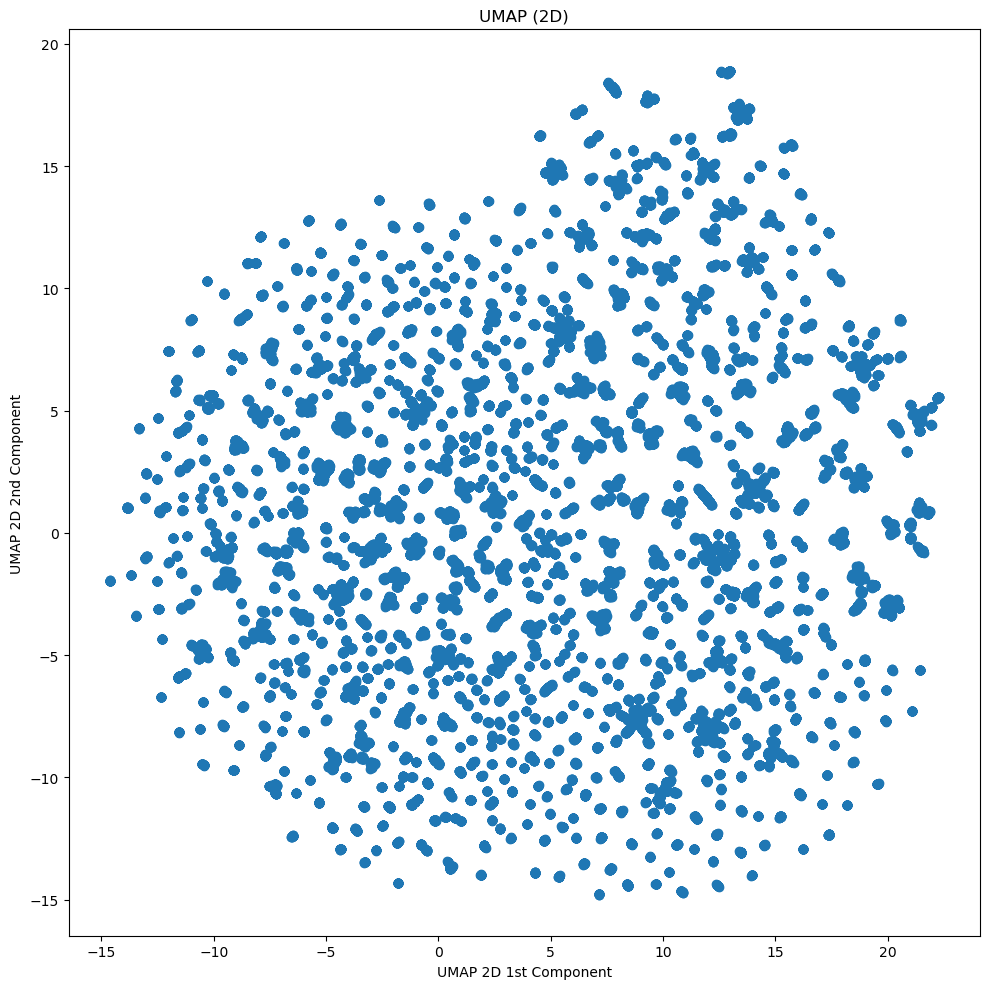

In [97]:
# Plot UMAP results (2D)
plt.figure(figsize=(10, 10))
plt.scatter(umap_result_2d[:, 0], umap_result_2d[:, 1])
plt.xlabel('UMAP 2D 1st Component')
plt.ylabel('UMAP 2D 2nd Component')
plt.title('UMAP (2D)')

plt.tight_layout()
plt.show()

In [98]:
'''
# Plot UMAP results (3D)
ax = plt.subplot(1, 3, 3, projection='3d')
ax.scatter3D(umap_result_3d[:, 0], umap_result_3d[:, 1], umap_result_3d[:, 2])
ax.set_xlabel('UMAP 3D 1st Component')
ax.set_ylabel('UMAP 3D 2nd Component')
ax.set_zlabel('UMAP 3D 3rd Component')
plt.title('UMAP (3D)')

plt.tight_layout()
plt.show()
'''

"\n# Plot UMAP results (3D)\nax = plt.subplot(1, 3, 3, projection='3d')\nax.scatter3D(umap_result_3d[:, 0], umap_result_3d[:, 1], umap_result_3d[:, 2])\nax.set_xlabel('UMAP 3D 1st Component')\nax.set_ylabel('UMAP 3D 2nd Component')\nax.set_zlabel('UMAP 3D 3rd Component')\nplt.title('UMAP (3D)')\n\nplt.tight_layout()\nplt.show()\n"

Text(0.5, 1.0, 't-SNE (2D)')

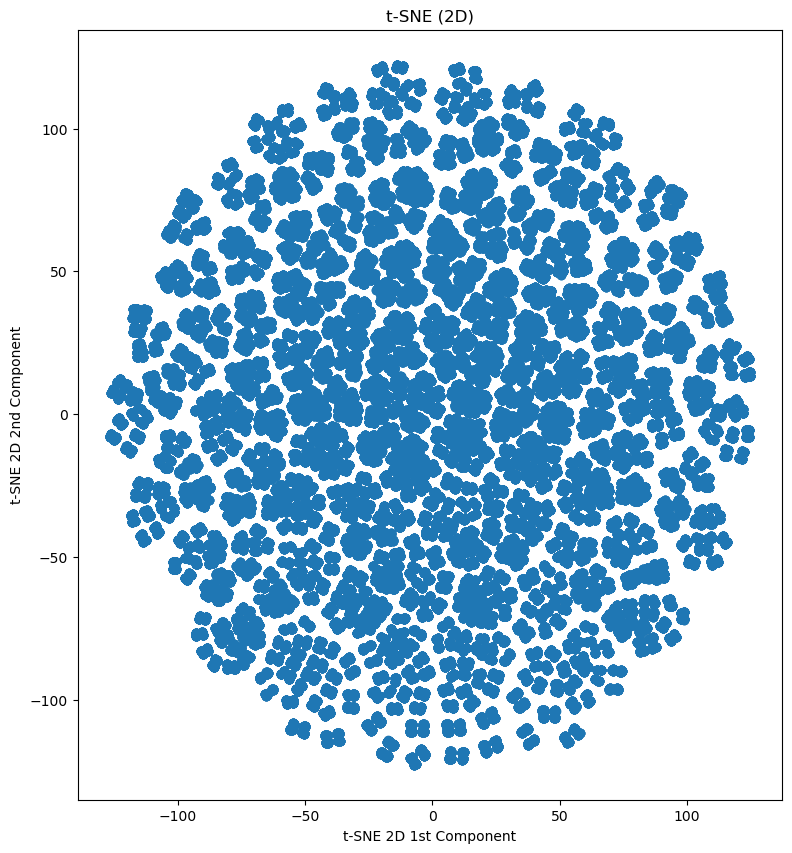

In [99]:
# Plot t-SNE results (2D)
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.scatter(tsne_result_2d[:, 0], tsne_result_2d[:, 1])
plt.xlabel('t-SNE 2D 1st Component')
plt.ylabel('t-SNE 2D 2nd Component')
plt.title('t-SNE (2D)')


In [100]:
'''
# Plot t-SNE results (3D)
ax = plt.subplot(1, 2, 2, projection='3d')
ax.scatter3D(tsne_result_3d[:, 0], tsne_result_3d[:, 1], tsne_result_3d[:, 2])
ax.set_xlabel('t-SNE 3D 1st Component')
ax.set_ylabel('t-SNE 3D 2nd Component')
ax.set_zlabel('t-SNE 3D 3rd Component')
plt.title('t-SNE (3D)')
'''

"\n# Plot t-SNE results (3D)\nax = plt.subplot(1, 2, 2, projection='3d')\nax.scatter3D(tsne_result_3d[:, 0], tsne_result_3d[:, 1], tsne_result_3d[:, 2])\nax.set_xlabel('t-SNE 3D 1st Component')\nax.set_ylabel('t-SNE 3D 2nd Component')\nax.set_zlabel('t-SNE 3D 3rd Component')\nplt.title('t-SNE (3D)')\n"

## Apply weighted clustering

In [101]:
# Extract weights from the last column of the DataFrame
weights = df_angles.iloc[:, -1]

/home/marina/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/marina/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/marina/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/marina/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 1

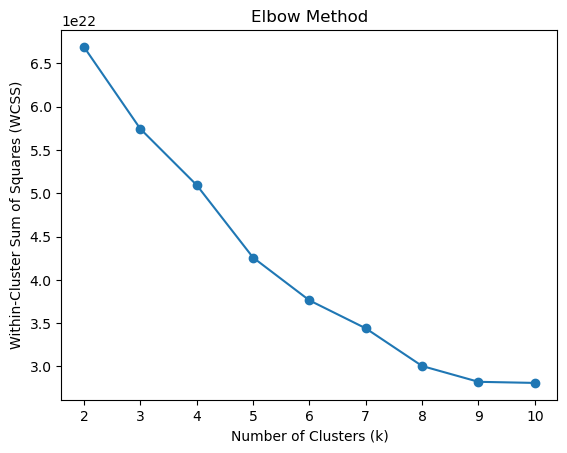

In [102]:
## Create an Elbow plot to deifne the optimal number of clusters
# Define the range of k values to consider
k_values = range(2, 11)

# Initialize an empty list to store the WCSS values
wcss = []

# Iterate over each k value
for k in k_values:
    # Create a KMeans instance with the current k value
    # Create an instance of the weighted K-means algorithm
    weighted_kmeans = KMeans(n_clusters=k,random_state=42) 

    # Modify the K-means algorithm to incorporate weights
    weighted_kmeans.fit(angles, sample_weight=weights)
    
  
    
    # Append the WCSS value to the list
    wcss.append( weighted_kmeans.inertia_)

# Plot the WCSS values against the number of clusters
plt.plot(k_values, wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method')
plt.show()

In [103]:
# We select the right number of k according to the Eblow plot
k=7
# Create an instance of the weighted K-means algorithm
weighted_kmeans = KMeans(n_clusters=k,random_state=42) 

# Modify the K-means algorithm to incorporate weights
weighted_kmeans.fit(angles, sample_weight=weights)

/home/marina/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=7, random_state=42)

In [104]:
# Get the cluster assignments for each data point
weighted_label= weighted_kmeans.labels_

# Get the cluster centers
cluster_centers = weighted_kmeans.cluster_centers_

### Visualize cluster centers using Multi-Dimensional Scaling

/home/marina/anaconda3/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/tmp/ipykernel_493469/966957102.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10')(np.linspace(0, 1, num_points))


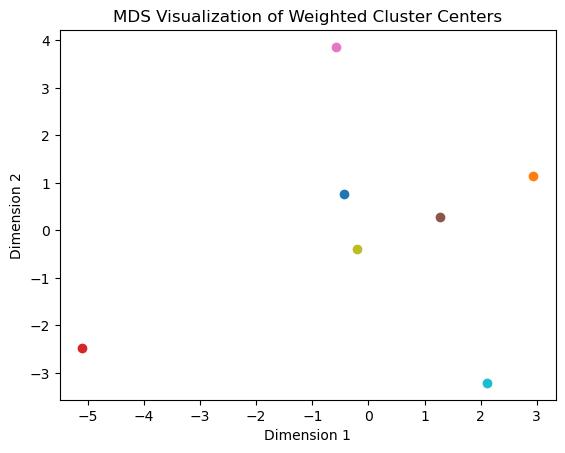

In [105]:
# Calculate dissimilarity matrix (using Euclidean distance)
dissimilarity_matrix = np.zeros((7, 7))
for i in range(7):
    for j in range(7):
        dissimilarity_matrix[i, j] = np.linalg.norm(cluster_centers[i] - cluster_centers[j])

# Apply MDS algorithm to reduce dimensionality to 2D
mds = MDS(n_components=2, dissimilarity='precomputed',random_state=42)
embedded_points = mds.fit_transform(dissimilarity_matrix)

# Assign different colors to each point
num_points = embedded_points.shape[0]
colors = plt.cm.get_cmap('tab10')(np.linspace(0, 1, num_points))

# Plot the embedded points in 2D with different colors
for i in range(num_points):
    plt.scatter(embedded_points[i, 0], embedded_points[i, 1], color=colors[i])

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('MDS Visualization of Weighted Cluster Centers')
plt.show()



### Analize the clusters 

In [106]:
#labels=labels_dbscan
labels=weighted_label

# Add the cluster labels as a new column to the DataFrame
angles['Cluster'] = labels

In [107]:
# Assuming your data is stored in a pandas DataFrame called 'data'
# Convert the labels to a pandas Series
labels_series = pd.Series(labels)

#Count the number of rows for each label
label_counts = labels_series.value_counts()

# Convert the label counts Series to a list
counts_list = label_counts.tolist()

# Print the list of counts
print(counts_list,len(counts_list))

[34560, 11519, 8640, 5760, 4320, 2160, 2160] 7


In [108]:
## Create a dictionary named position_frequency_dict to store the frequency of apperance of amino acid's rotamers in each cluster

# Define the length of the sequence
sequence_length = 11
number_range = 21

# Initialize a dictionary to store the position-specific frequency for each cluster
position_frequency_dict = {}

# Iterate over each cluster label
for cluster_label in angles['Cluster'].unique():
    # Filter the DataFrame to get the rows belonging to the current cluster
    cluster_df = df_angles[angles['Cluster'] == cluster_label]

    # Initialize the nested dictionary for the current cluster
    cluster_position_frequency = {position: {number: 0 for number in range(1, number_range + 1)} for position in range(1, sequence_length + 1)}

    # Iterate over the rows in the current cluster
    for _, row in cluster_df.iterrows():
        # Assuming the sequence values are stored in a column named 'conformations' in df_angles DataFrame
        sequence_value = row['conformations']

        # Extract the numbers from the sequence using regular expressions
        numbers = re.findall(r'\d+', sequence_value)

        # Iterate over each position in the sequence
        for position in range(sequence_length):
            # Check if the position is within the available number range
            if position < len(numbers):
                number = int(numbers[position])

                # Increment the frequency count for the current number and position
                cluster_position_frequency[position+1][number] += 1

    # Store the position-specific frequency for the current cluster in the overall dictionary
    position_frequency_dict[cluster_label] = cluster_position_frequency

# Print the position-specific frequency for each cluster
for cluster, position_frequency in position_frequency_dict.items():
    print(f"Cluster {cluster}:")
    for position, number_frequency in position_frequency.items():
        print(f"Position {position}:")
        print(number_frequency)

Cluster 4:
Position 1:
{1: 5759, 2: 0, 3: 0, 4: 5760, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0}
Position 2:
{1: 3839, 2: 0, 3: 3840, 4: 3840, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0}
Position 3:
{1: 2303, 2: 2304, 3: 2304, 4: 2304, 5: 0, 6: 2304, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0}
Position 4:
{1: 2879, 2: 2880, 3: 2880, 4: 0, 5: 2880, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0}
Position 5:
{1: 0, 2: 2879, 3: 2880, 4: 2880, 5: 2880, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0}
Position 6:
{1: 3839, 2: 3840, 3: 3840, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0}
Position 7:
{1: 0, 2

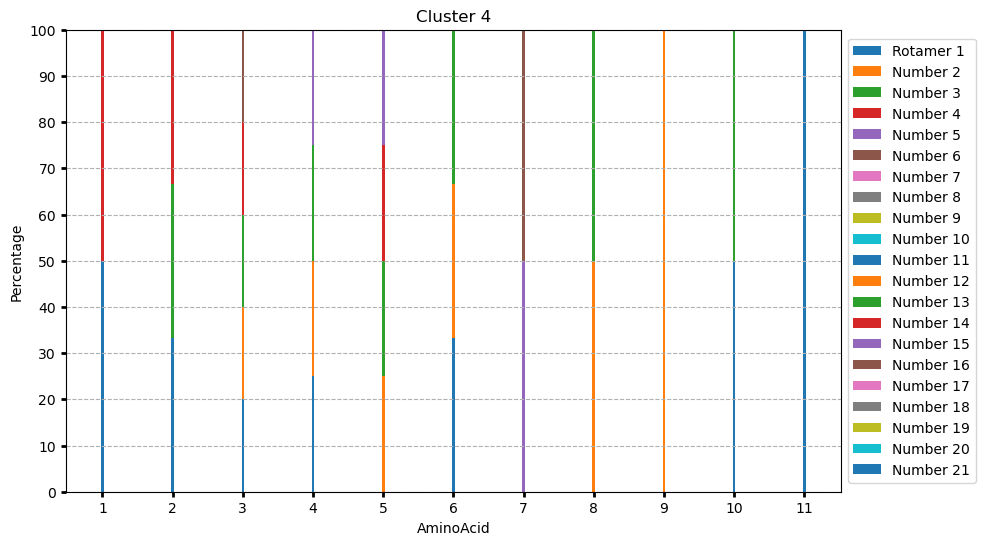

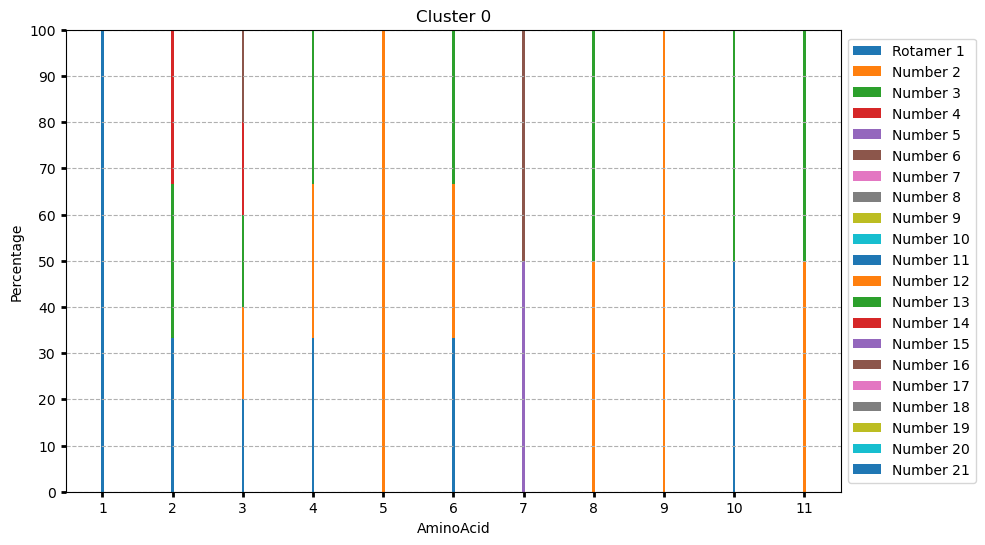

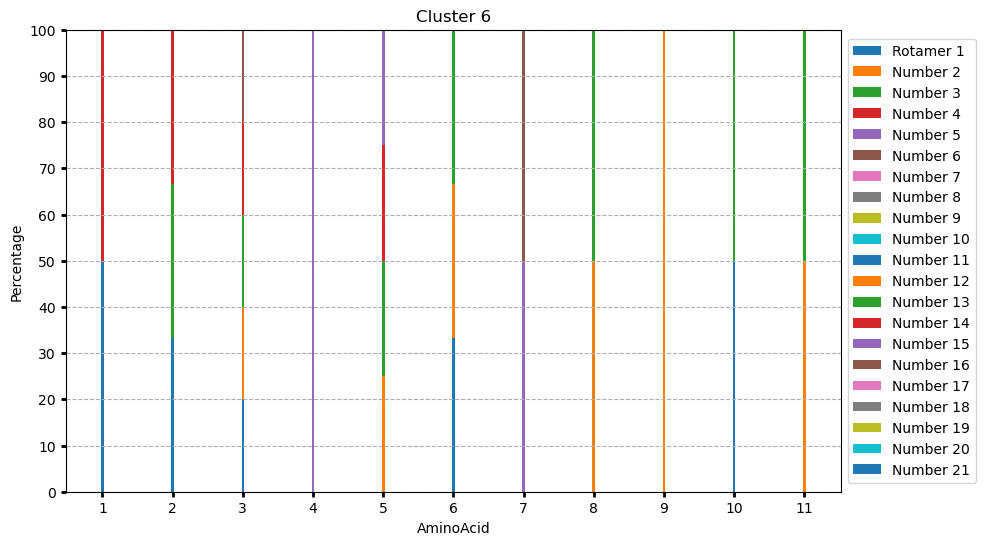

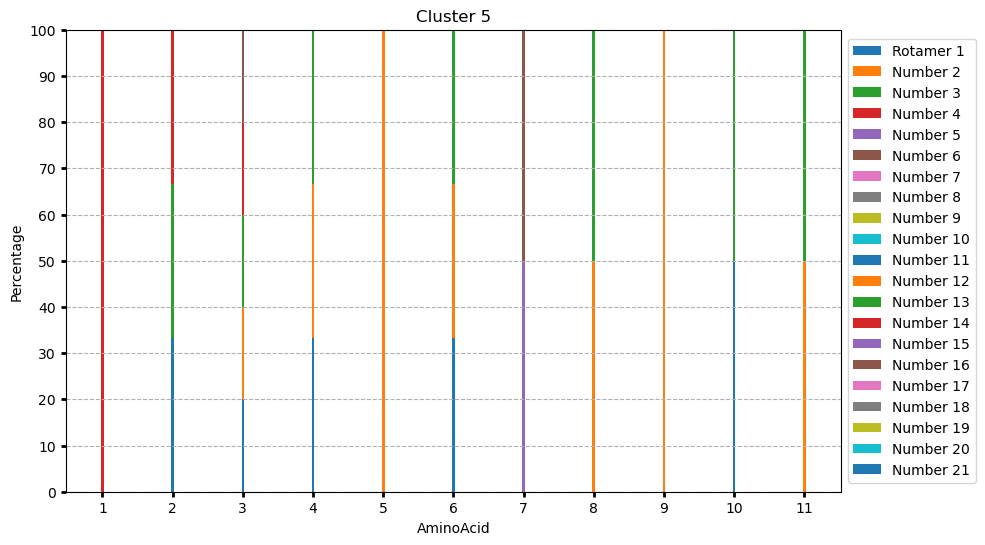

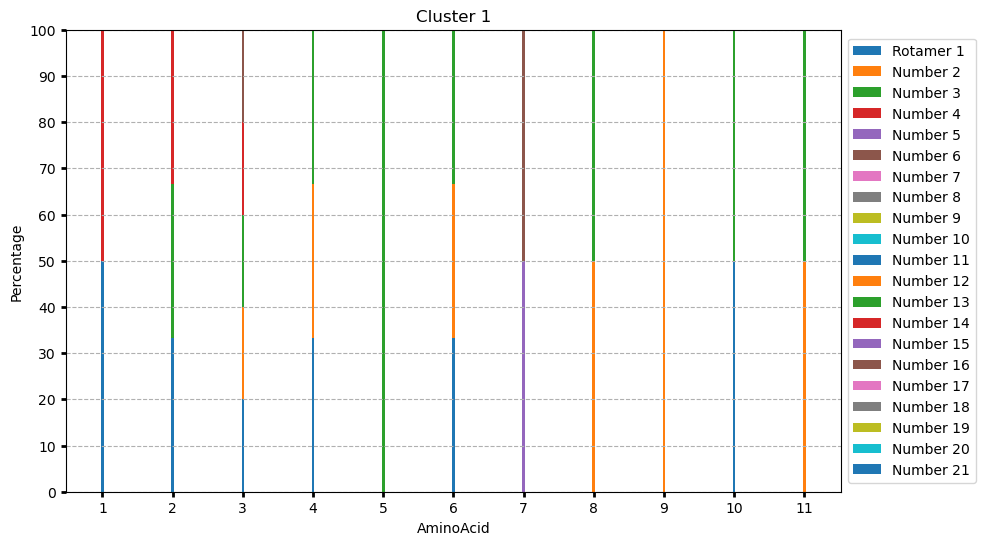

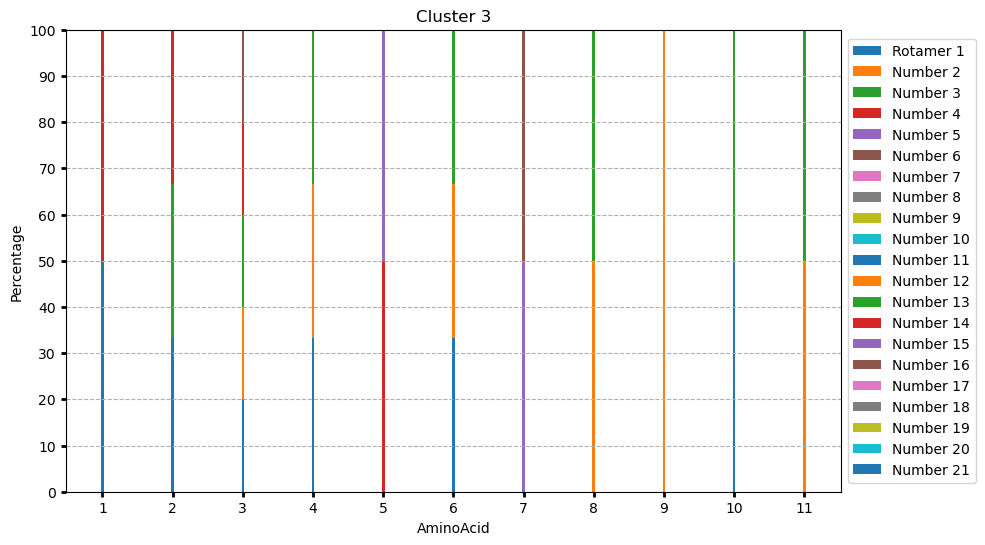

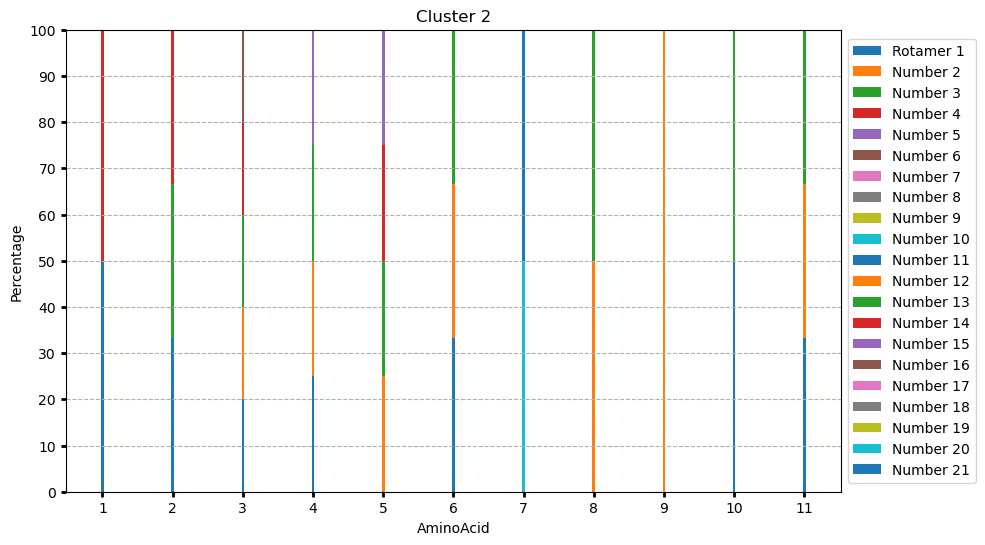

In [109]:
##Create barplots for each cluster representing each rotamers apperance in every aminoacid

# Iterate over each cluster and its position-frequency dictionary
for cluster, position_frequency in position_frequency_dict.items():
    # Create arrays to store the percentages for each number at each position
    percentages = np.zeros((number_range, sequence_length))

    # Calculate the percentages for each number at each position
    for position, number_frequency in position_frequency.items():
        total_count = sum(number_frequency.values())
        if total_count > 0:
            for number, frequency in number_frequency.items():
                percentages[number-1, position-1] = frequency / total_count * 100

    # Create a bar plot for the current cluster
    plt.figure(figsize=(10, 6))  # Adjust the figure size as desired
    positions = np.arange(1, sequence_length + 1)
    width = 0.8 / number_range  # Width of each bar

    # Calculate the cumulative percentages for each position
    cumulative_percentages = np.cumsum(percentages, axis=0)

    # Plot the bars with different colors based on the cumulative percentages
    for number in range(number_range):
        if number == 0:
            plt.bar(positions, cumulative_percentages[number], width, label=f'Rotamer {number+1}')
        else:
            plt.bar(positions, cumulative_percentages[number] - cumulative_percentages[number-1], width, bottom=cumulative_percentages[number-1], label=f'Number {number+1}')

    plt.xlabel('AminoAcid')
    plt.ylabel('Percentage')
    plt.title(f'Cluster {cluster}')
    plt.ylim(0, 100)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Move the legend to the right side
    plt.grid(axis='y', linestyle='--')  # Add grid lines
    plt.xticks(positions)
    plt.yticks(np.arange(0, 101, 10))
    plt.tick_params(axis='both', which='major', width=2)  # Increase tick width

    # Set thicker line widths for bars
    for container in plt.gca().containers:
        plt.setp(container, linewidth=2)

    plt.show()

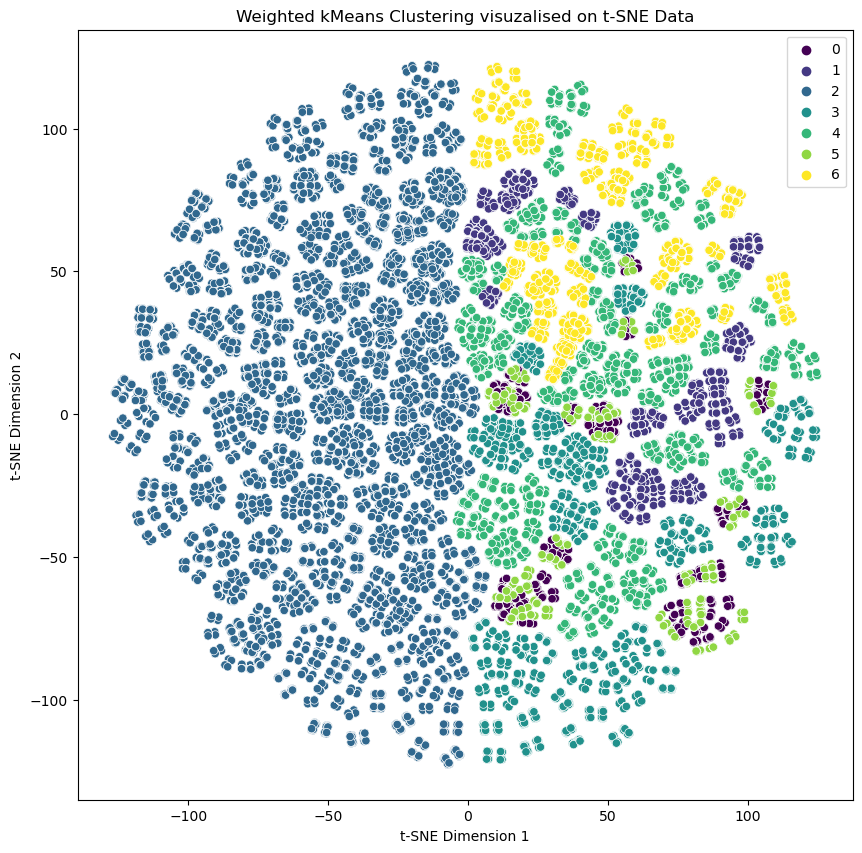

In [110]:
#Visualize the clusters using the t-SNE reduced data
plt.figure(figsize=(10, 10))
sns.scatterplot(x=tsne_result_2d[:, 0], y=tsne_result_2d[:, 1], hue=weighted_label, palette='viridis', #legend='full'
               )
plt.title('Weighted kMeans Clustering visuzalised on t-SNE Data')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

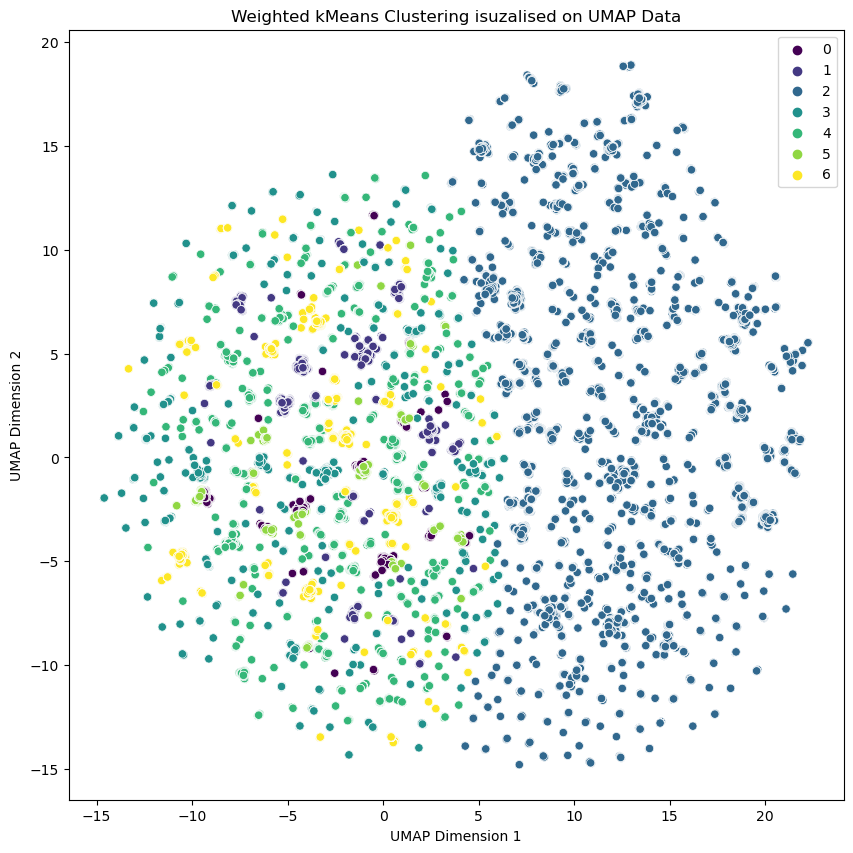

In [111]:
#Visualize the clusters using the UMAP reduced data
plt.figure(figsize=(10, 10))
sns.scatterplot(x=umap_result_2d[:, 0], y=umap_result_2d[:, 1], hue=weighted_label, palette='viridis', #legend='full'
               )
plt.title('Weighted kMeans Clustering isuzalised on UMAP Data')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

# Unweighted Clustering

/home/marina/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/marina/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/marina/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/marina/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 1

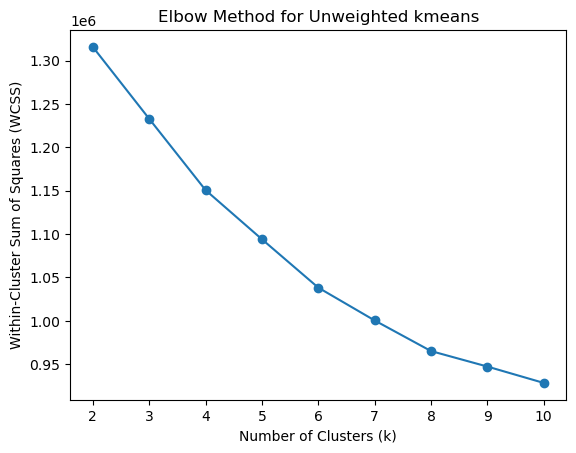

In [112]:
##Create an elbow plot to define the number of clusters
# Define the range of k values to consider
angles = df_angles.iloc[:, 1:-1]
k_values = range(2, 11)

# Initialize an empty list to store the WCSS values
wcss = []

# Iterate over each k value
for k in k_values:
    # Create a KMeans instance with the current k value
    kmeans = KMeans(n_clusters=k, random_state=42)
    
    # Fit the KMeans model to your data
    kmeans.fit(angles)
    
    # Append the WCSS value to the list
    wcss.append(kmeans.inertia_)

# Plot the WCSS values against the number of clusters
plt.plot(k_values, wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Unweighted kmeans')
plt.show()


We observe that the optimal number of clusters is 8

In [113]:
# Create and fit the kMeans model
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(angles)

# Get the cluster centers
cluster_centers =kmeans.cluster_centers_

# Access the cluster labels
labels_kmeans = kmeans.labels_

# Convert the list of labels to a pandas Series
labels_series = pd.Series(labels_kmeans)

# Count the number of rows for each label
label_counts = labels_series.value_counts()

# Convert the label counts Series to a list
counts_list = label_counts.tolist()

# Print the list of counts
print(counts_list,len(counts_list))

np.sort(counts_list)[-10:]


/home/marina/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[11520, 11519, 8640, 8640, 8640, 8640, 5760, 5760] 8


array([ 5760,  5760,  8640,  8640,  8640,  8640, 11519, 11520])

### Visualize cluster centers using Multi-Dimensional Scaling

/home/marina/anaconda3/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/tmp/ipykernel_493469/1507623151.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10')(np.linspace(0, 1, num_points))


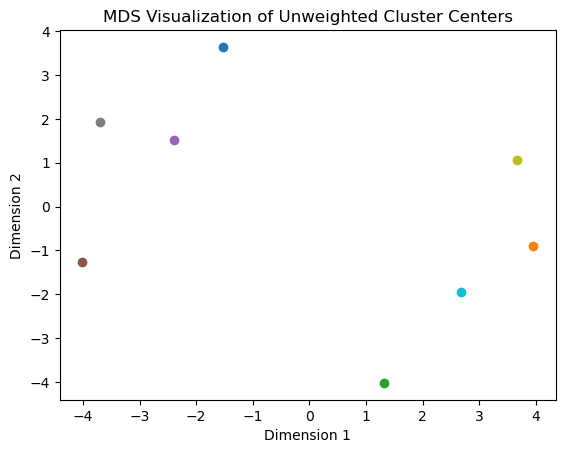

In [114]:
# Calculate dissimilarity matrix (using Euclidean distance)
dissimilarity_matrix = np.zeros((8, 8))
for i in range(8):
    for j in range(8):
        dissimilarity_matrix[i, j] = np.linalg.norm(cluster_centers[i] - cluster_centers[j])

# Apply MDS algorithm to reduce dimensionality to 2D
mds = MDS(n_components=2, dissimilarity='precomputed',random_state=42)
embedded_points = mds.fit_transform(dissimilarity_matrix)

# Assign different colors to each point
num_points = embedded_points.shape[0]
colors = plt.cm.get_cmap('tab10')(np.linspace(0, 1, num_points))

# Plot the embedded points in 2D with different colors
for i in range(num_points):
    plt.scatter(embedded_points[i, 0], embedded_points[i, 1], color=colors[i])

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('MDS Visualization of Unweighted Cluster Centers')
plt.show()


In [115]:
#Keep the labels according to choice 
labels=labels_kmeans

# Add the cluster labels as a new column to the DataFrame
angles['Cluster'] = labels

# Convert the list of labels to a pandas Series
labels_series = pd.Series(labels_kmeans)

# Count the number of rows for each label
label_counts = labels_series.value_counts()

# Convert the label counts Series to a list
counts_list = label_counts.tolist()

# Print the list of counts
print(counts_list,len(counts_list))

np.sort(counts_list)[-10:]

[11520, 11519, 8640, 8640, 8640, 8640, 5760, 5760] 8


array([ 5760,  5760,  8640,  8640,  8640,  8640, 11519, 11520])

In [116]:
## Create a dictionary named position_frequency_dict to store the frequency of apperance of amino acid's rotamers in each cluster
# Define the length of the sequence
sequence_length = 11
number_range = 21

# Initialize a dictionary to store the position-specific frequency for each cluster
position_frequency_dict = {}

# Iterate over each cluster label
for cluster_label in angles['Cluster'].unique():
    # Filter the DataFrame to get the rows belonging to the current cluster
    cluster_df = df_angles[angles['Cluster'] == cluster_label]

    # Initialize the nested dictionary for the current cluster
    cluster_position_frequency = {position: {number: 0 for number in range(1, number_range + 1)} for position in range(1, sequence_length + 1)}

    # Iterate over the rows in the current cluster
    for _, row in cluster_df.iterrows():
        # Assuming the sequence values are stored in a column named 'conformations' in df_angles DataFrame
        sequence_value = row['conformations']

        # Extract the numbers from the sequence using regular expressions
        numbers = re.findall(r'\d+', sequence_value)

        # Iterate over each position in the sequence
        for position in range(sequence_length):
            # Check if the position is within the available number range
            if position < len(numbers):
                number = int(numbers[position])

                # Increment the frequency count for the current number and position
                cluster_position_frequency[position+1][number] += 1

    # Store the position-specific frequency for the current cluster in the overall dictionary
    position_frequency_dict[cluster_label] = cluster_position_frequency

# Print the position-specific frequency for each cluster
for cluster, position_frequency in position_frequency_dict.items():
    print(f"Cluster {cluster}:")
    for position, number_frequency in position_frequency.items():
        print(f"Position {position}:")
        print(number_frequency)


Cluster 3:
Position 1:
{1: 5759, 2: 0, 3: 0, 4: 5760, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0}
Position 2:
{1: 3839, 2: 0, 3: 3840, 4: 3840, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0}
Position 3:
{1: 2303, 2: 2304, 3: 2304, 4: 2304, 5: 0, 6: 2304, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0}
Position 4:
{1: 3839, 2: 3840, 3: 3840, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0}
Position 5:
{1: 0, 2: 2879, 3: 2880, 4: 2880, 5: 2880, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0}
Position 6:
{1: 5759, 2: 5760, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0}
Position 7:
{1: 0, 2: 0, 3

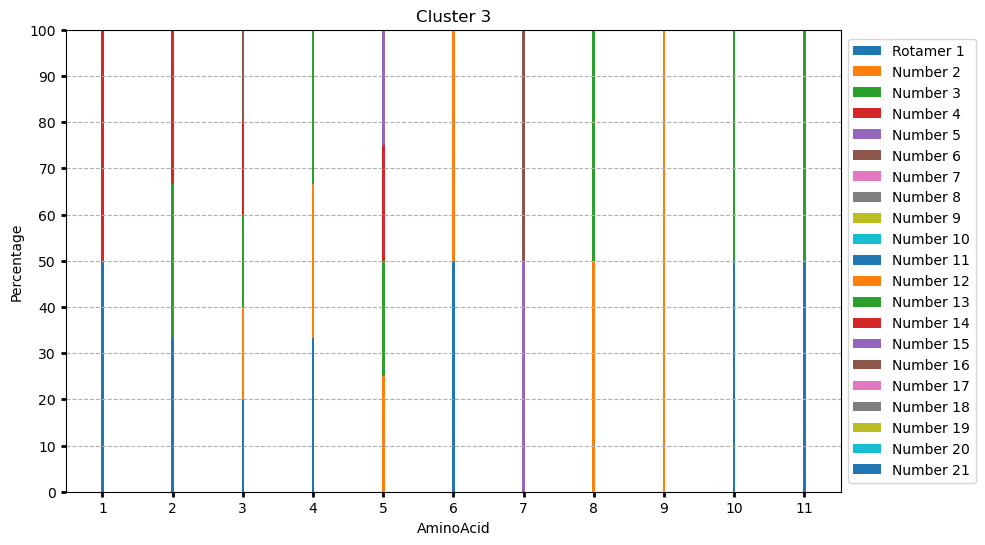

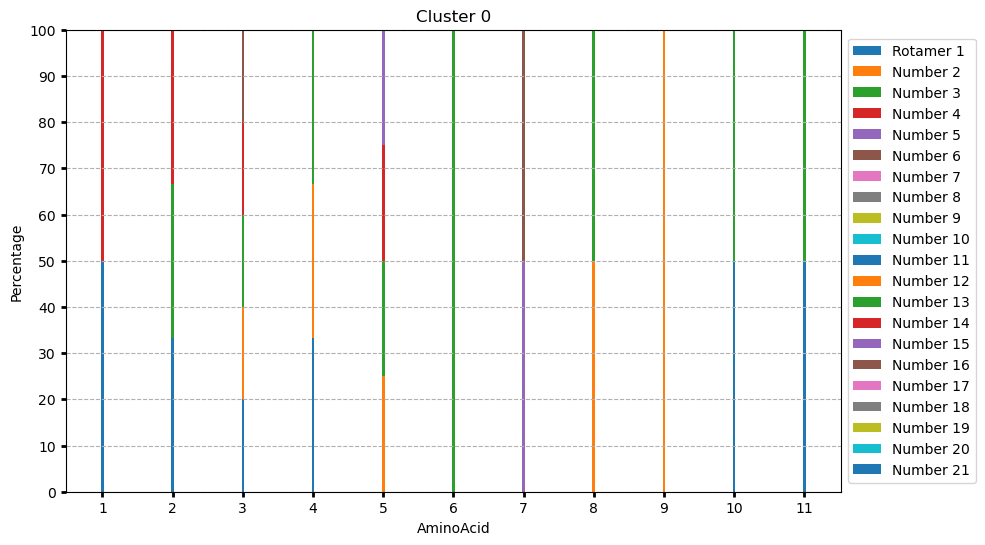

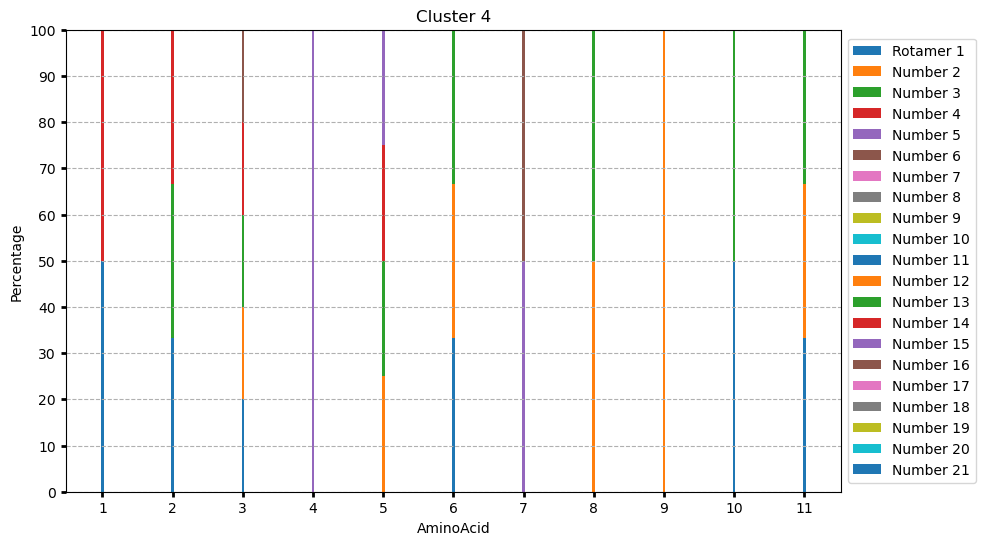

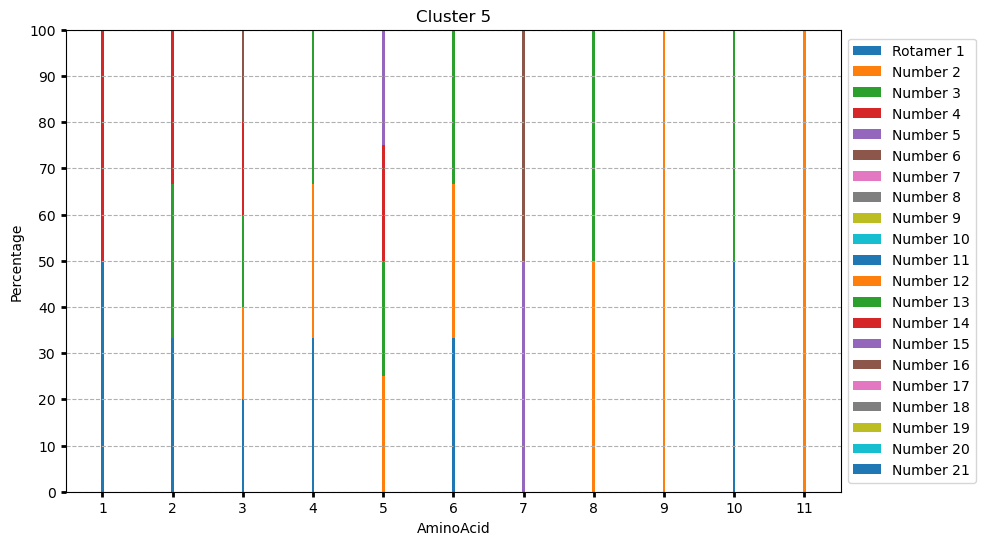

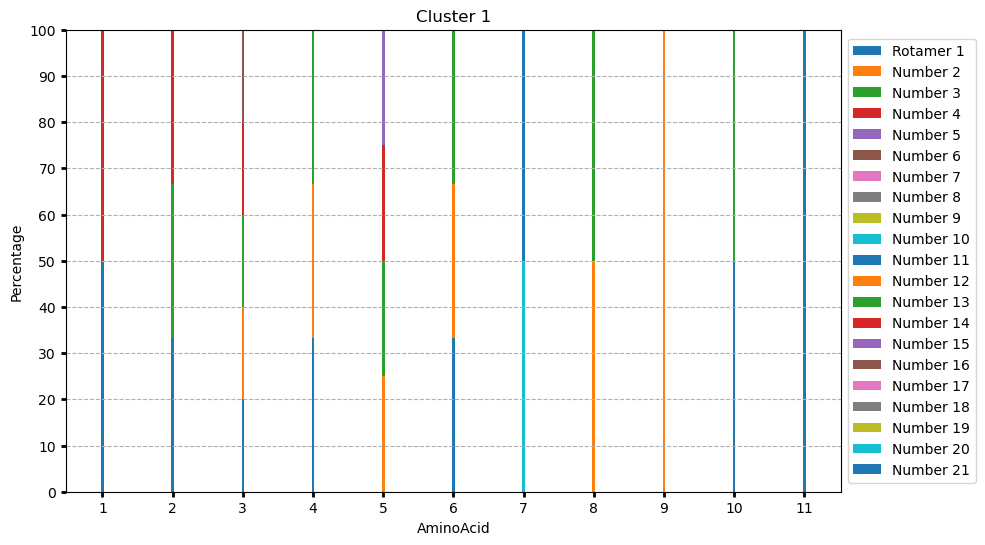

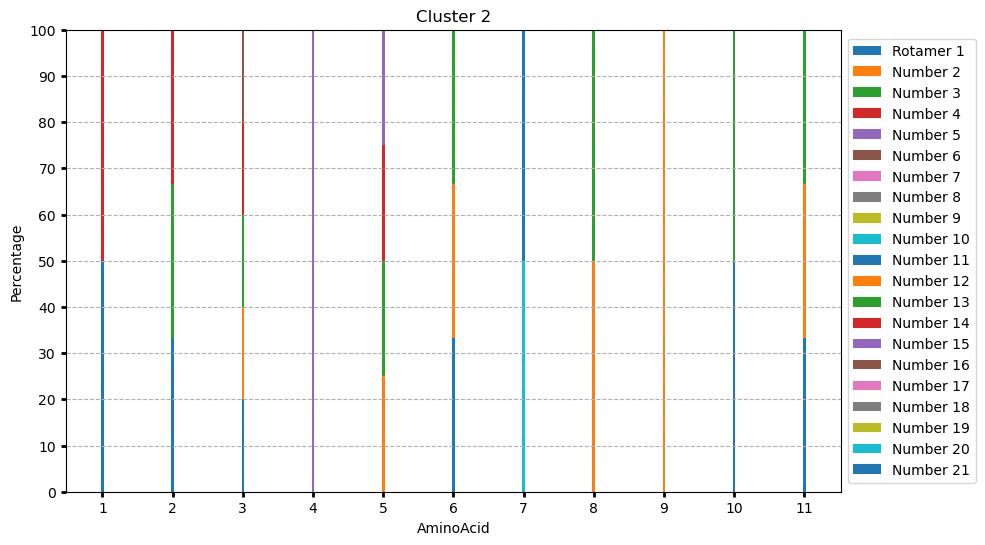

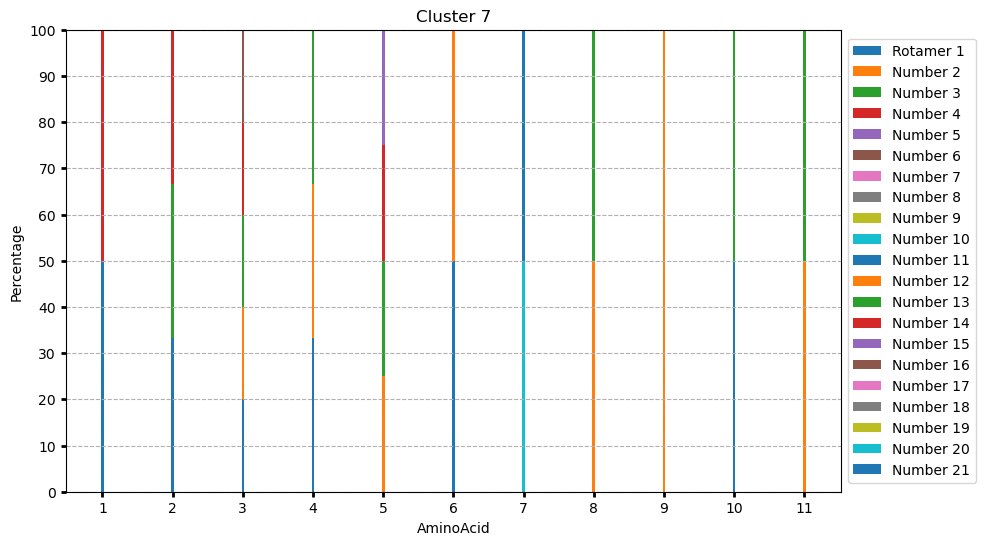

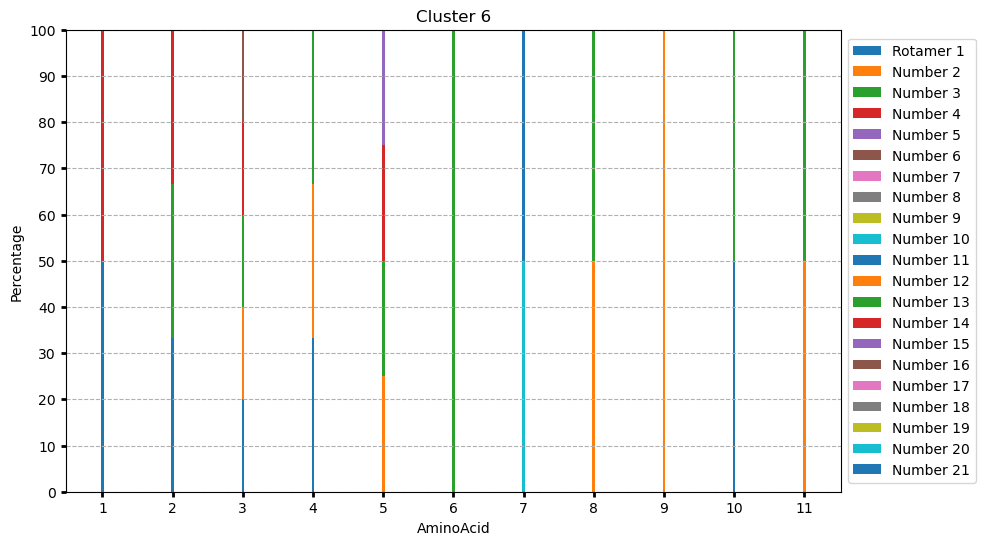

In [117]:
##Create barplots for each cluster representing each rotamers apperance in every aminoacid
# Iterate over each cluster and its position-frequency dictionary
for cluster, position_frequency in position_frequency_dict.items():
    # Create arrays to store the percentages for each number at each position
    percentages = np.zeros((number_range, sequence_length))

    # Calculate the percentages for each number at each position
    for position, number_frequency in position_frequency.items():
        total_count = sum(number_frequency.values())
        if total_count > 0:
            for number, frequency in number_frequency.items():
                percentages[number-1, position-1] = frequency / total_count * 100

    # Create a bar plot for the current cluster
    plt.figure(figsize=(10, 6))  # Adjust the figure size as desired
    positions = np.arange(1, sequence_length + 1)
    width = 0.8 / number_range  # Width of each bar

    # Calculate the cumulative percentages for each position
    cumulative_percentages = np.cumsum(percentages, axis=0)

    # Plot the bars with different colors based on the cumulative percentages
    for number in range(number_range):
        if number == 0:
            plt.bar(positions, cumulative_percentages[number], width, label=f'Rotamer {number+1}')
        else:
            plt.bar(positions, cumulative_percentages[number] - cumulative_percentages[number-1], width, bottom=cumulative_percentages[number-1], label=f'Number {number+1}')

    plt.xlabel('AminoAcid')
    plt.ylabel('Percentage')
    plt.title(f'Cluster {cluster}')
    plt.ylim(0, 100)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Move the legend to the right side
    plt.grid(axis='y', linestyle='--')  # Add grid lines
    plt.xticks(positions)
    plt.yticks(np.arange(0, 101, 10))
    plt.tick_params(axis='both', which='major', width=2)  # Increase tick width

    # Set thicker line widths for bars
    for container in plt.gca().containers:
        plt.setp(container, linewidth=2)

    plt.show()


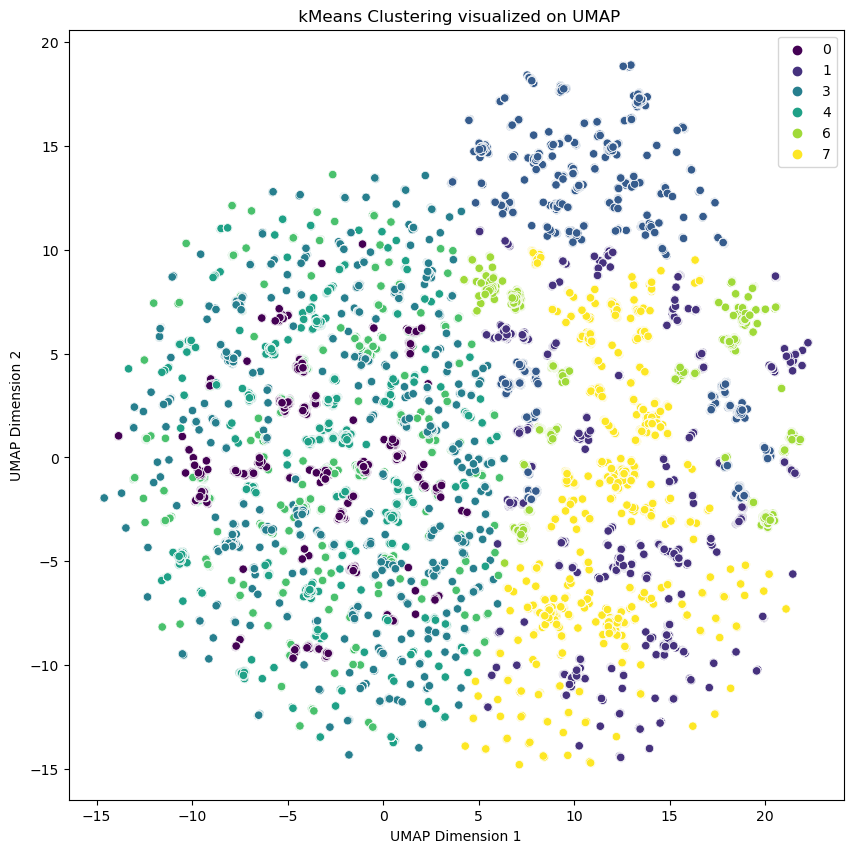

In [118]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=umap_result_2d[:, 0], y=umap_result_2d[:, 1], hue=labels
, palette='viridis', #legend='full'
               )
plt.title(' kMeans Clustering visualized on UMAP')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

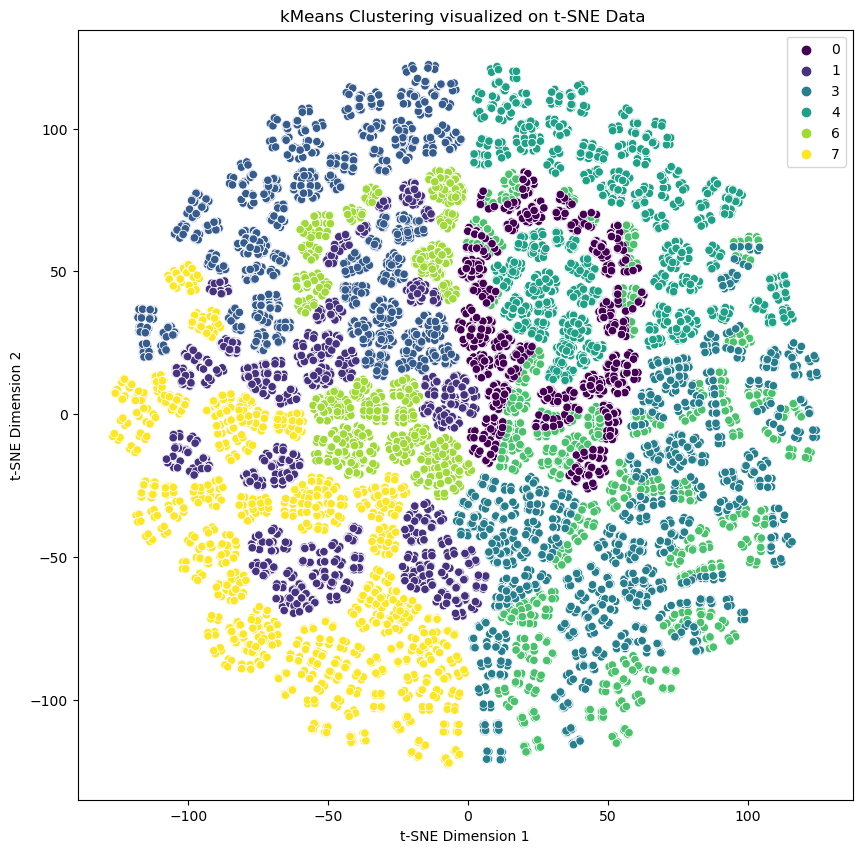

In [119]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=tsne_result_2d[:, 0], y=tsne_result_2d[:, 1], hue=labels, palette='viridis', #legend='full'
               )
plt.title('kMeans Clustering visualized on t-SNE Data ')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()